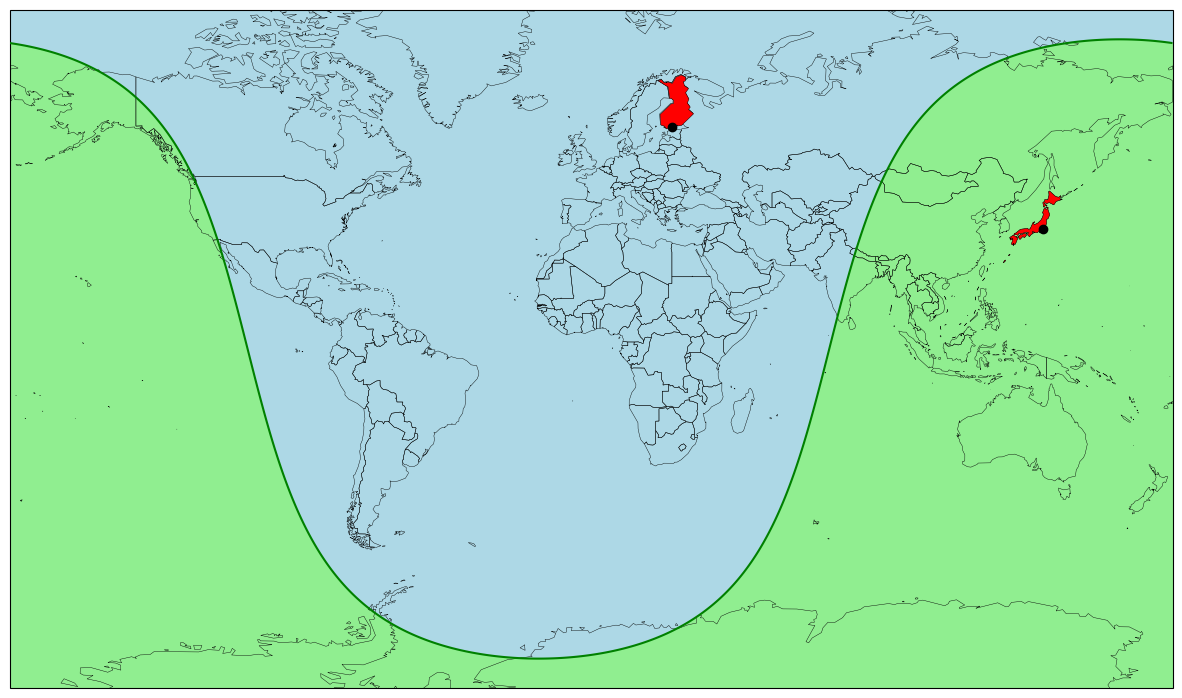

In [1]:
# 球面两点的球面中垂线

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from geopy.distance import geodesic

# 读取地图数据
world = gpd.read_file('./worldmap4/world.json')

# 设置投影
world = world.to_crs(ccrs.PlateCarree())

# 选取目标点所属国家
c1 = world[world['name'] == '芬兰']
c2 = world[world['name'] == '日本']

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller()})

# 绘制世界地图
world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=1)

# 将目标点所属国家填充为红色
c1.plot(ax=ax, color='red', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=2)
c2.plot(ax=ax, color='red', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=2)

# 设置两个目标点
lat1, lon1 = 60.17104926742669, 24.93805711554702
lat2, lon2 = 35.680880043438144, 139.77022963207594
# 生成经纬度网格
lats = np.linspace(-90, 90, 300)
lons = np.linspace(-180, 180, 600)
lon_grid, lat_grid = np.meshgrid(lons, lats)
distance_diff = np.zeros(lon_grid.shape)

# 计算每个网格点到目标点的球面距离
for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        point = (lat_grid[i, j], lon_grid[i, j])
        d1 = geodesic(point, (lat1, lon1)).kilometers
        d2 = geodesic(point, (lat2, lon2)).kilometers
        distance_diff[i, j] = d1 - d2

# 绘制填充等高线，等价于填充分界线两侧颜色
contourf = ax.contourf(lon_grid, lat_grid, distance_diff, levels=[-1e10, 0, 1e10], colors=['lightblue', 'lightgreen'], transform=ccrs.PlateCarree(), zorder=0)

# 绘制等高线，等价于绘制平分线
contour = ax.contour(lon_grid, lat_grid, distance_diff, levels=[0], colors='green', transform=ccrs.PlateCarree(), zorder=3)

# 绘制目标点
ax.scatter([lon1, lon2], [lat1, lat2], color='black', marker='o', transform=ccrs.PlateCarree(), zorder=4)

# 设置横纵坐标刻度不可见
ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# 设置地图显示范围
ax.set_extent([180, -180, -80, 80], crs=ccrs.PlateCarree())

# 保存图像并显示
# plt.savefig('output6.png', dpi=300, bbox_inches='tight')
plt.show()


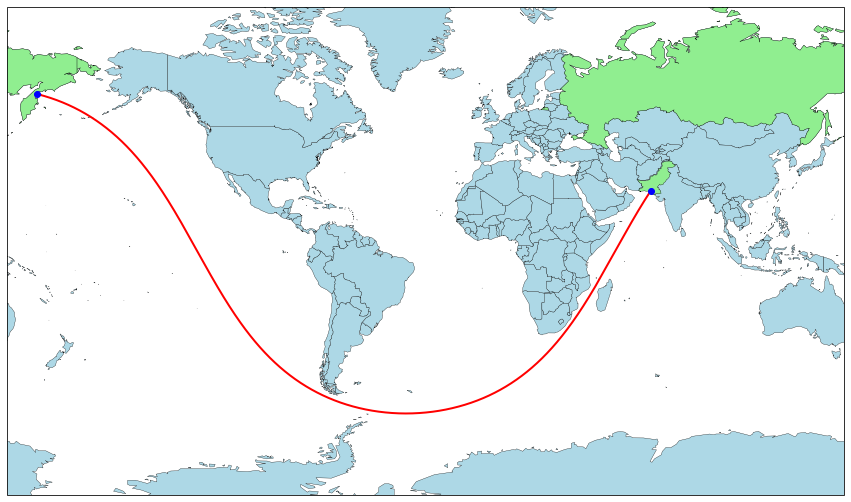

In [8]:
#球面两点的较长大地线

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Geod

# 读取世界地图数据
world = gpd.read_file('world.zh.json')
world = world.to_crs(ccrs.PlateCarree())

# 提取俄罗斯和巴基斯坦的数据
c1 = world[world['name'] == '俄罗斯']
c2 = world[world['name'] == '巴基斯坦']

# prepare points
# P1
lat1, lon1 = 59.18232447782983, 162.90673502275226
# P1's antipode
lat1a = -lat1
lon1a = lon1 - 180
# p2
lat2, lon2 = 25.174689841781433, 66.75388912356865
# P2's antipode
lat2a = -lat2
lon2a = lon2 - 180


# 创建图形和投影
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=-30)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
c1.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
c2.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

# 使用 pyproj 的 Geod 计算大圆弧线
geod = Geod(ellps="WGS84")

# Geodetic lines: P2-P1_antipode
num_points = 200
point1 = geod.npts(lon2, lat2, lon1a, lat1a, num_points)
# Geodetic lines: P1_antipode-P2_antipode
point2 = geod.npts(lon1a, lat1a, lon2a, lat2a, num_points)
# Geodetic lines: P2_antipode-P1
point3 = geod.npts(lon2a, lat2a, lon1, lat1, num_points)
points = point1 + point2 + point3

# 提取较长的一段路径
lons, lats = zip(*points)
# 绘制较长的大圆弧线
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.Geodetic())

# 在地图上标记特定的经纬度点
ax.scatter([lon1, lon2], [lat1, lat2], color='b', marker='o', zorder=5, transform=ccrs.PlateCarree())

# 设置图形的外观和保存图像
ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_extent([180, -180, -80, 80], crs=ccrs.PlateCarree())
# plt.savefig('outputN.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# 读取美国各州的GeoJSON文件
world = gpd.read_file('./province/ne_10m_admin_1_states_provinces.shp')
us = world[world['admin'] == 'United States of America']
us = us.to_crs(ccrs.PlateCarree())


# 创建图并添加节点和边
G = nx.Graph()

for index, state in us.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in us.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])

# 标记直接与海洋接壤的州（假设这些州已经预先定义）
ocean_bordering_states = [
    'California', 'Oregon', 'Washington', 'Texas', 'Louisiana', 'Mississippi', 
    'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia',
    'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Hawaii'
]

# 使用BFS计算每个州到达海洋的最小间隔州数
min_steps_to_ocean = {state: float('inf') for state in G.nodes}
print(min_steps_to_ocean)

for ocean_state in ocean_bordering_states:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue

# 打印结果
for state, steps in min_steps_to_ocean.items():
    print(f'{state}: {steps} steps to the nearest ocean')




{'Washington': inf, 'Idaho': inf, 'Oregon': inf, 'Montana': inf, 'Utah': inf, 'Wyoming': inf, 'Nevada': inf, 'North Dakota': inf, 'South Dakota': inf, 'Minnesota': inf, 'Michigan': inf, 'Iowa': inf, 'Wisconsin': inf, 'Ohio': inf, 'Illinois': inf, 'Indiana': inf, 'Pennsylvania': inf, 'Kentucky': inf, 'West Virginia': inf, 'New York': inf, 'Maryland': inf, 'Delaware': inf, 'New Jersey': inf, 'Vermont': inf, 'Connecticut': inf, 'Massachusetts': inf, 'New Hampshire': inf, 'Maine': inf, 'Arizona': inf, 'California': inf, 'New Mexico': inf, 'Colorado': inf, 'Texas': inf, 'Oklahoma': inf, 'Louisiana': inf, 'Arkansas': inf, 'Alaska': inf, 'Mississippi': inf, 'Alabama': inf, 'Tennessee': inf, 'Florida': inf, 'Georgia': inf, 'South Carolina': inf, 'North Carolina': inf, 'Virginia': inf, 'District of Columbia': inf, 'Rhode Island': inf, 'Hawaii': inf, 'Nebraska': inf, 'Kansas': inf, 'Missouri': inf}
Washington: 0 steps to the nearest ocean
Idaho: 1 steps to the nearest ocean
Oregon: 0 steps to th

In [26]:
import geopandas as gpd
import pandas as pd

province = gpd.read_file('./chinamap/province/test.json')
province.head(10)
province.to_csv('china_city2.csv', index=False, encoding='utf-8-sig')
# c1 = rivers[rivers['name_zh'] == '多瑙河']
# c1

(0.993248, 0.906157, 0.143936, 1.0)
['Washington', 'Oregon', 'New York', 'Maryland', 'Delaware', 'New Jersey', 'Connecticut', 'Massachusetts', 'New Hampshire', 'Maine', 'California', 'Texas', 'Louisiana', 'Alaska', 'Mississippi', 'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia', 'Rhode Island', 'Hawaii']
(0.360741, 0.785964, 0.387814, 1.0)
['Idaho', 'Nevada', 'Pennsylvania', 'Kentucky', 'West Virginia', 'Vermont', 'Arizona', 'New Mexico', 'Oklahoma', 'Arkansas', 'Tennessee', 'District of Columbia']
(0.128729, 0.563265, 0.551229, 1.0)
['Montana', 'Utah', 'Wyoming', 'Ohio', 'Illinois', 'Indiana', 'Colorado', 'Kansas', 'Missouri']
(0.231674, 0.318106, 0.544834, 1.0)
['North Dakota', 'South Dakota', 'Michigan', 'Iowa', 'Wisconsin', 'Nebraska']
(0.267004, 0.004874, 0.329415, 1.0)
['Minnesota']


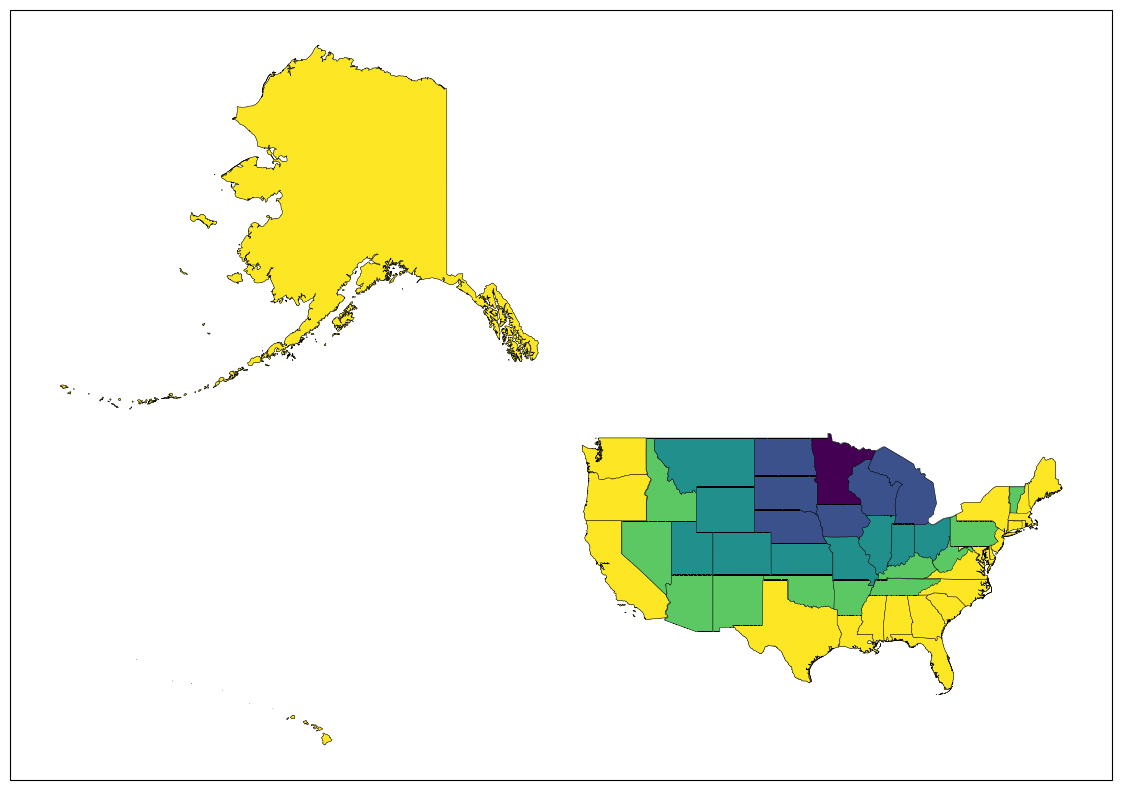

In [21]:
# 行政区分析

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


world = gpd.read_file('./province/ne_10m_admin_1_states_provinces.shp')
us = world[world['admin'] == 'United States of America']
us = us.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
us.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

G = nx.Graph()

for index, state in us.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in us.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


ocean_bordering_states = [
    'California', 'Oregon', 'Washington', 'Texas', 'Louisiana', 'Mississippi', 
    'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia',
    'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Hawaii', 'Alaska'
]

min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in ocean_bordering_states:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue

colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=stepMax)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, stepMax+1):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = us[us['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
 


ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# ax.set_extent([-25, 40, 33, 68], crs=ccrs.PlateCarree())
# plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()


(0.993248, 0.906157, 0.143936, 1.0)
['汕尾市', '漳州市', '揭阳市', '潮州市', '舟山市', '葫芦岛市', '秦皇岛市', '锦州市', '深圳市', '惠州市', '香港特别行政区', '东莞市', '泉州市', '福州市', '大连市', '丹东市', '营口市', '嘉兴市', '滨州市', '珠海市', '澳门特别行政区', '中山市', '江门市', '厦门市', '莆田市', '日照市', '潍坊市', '连云港市', '盘锦市', '唐山市', '天津市', '台州市', '盐城市', '南通市', '汕头市', '威海市', '烟台市', '宁波市', '阳江市', '茂名市', '广州市', '青岛市', '三亚市', '陵水黎族自治县', '乐东黎族自治县', '台湾省', '万宁市', '昌江黎族自治县', '东方市', '东营市', '沧州市', '儋州市', '临高县', '澄迈县', '海口市', '琼海市', '文昌市', '上海市', '宁德市', '温州市', '防城港市', '钦州市', '北海市', '三沙市', '湛江市']
(0.360741, 0.785964, 0.387814, 1.0)
['梅州市', '河源市', '龙岩市', '朝阳市', '承德市', '阜新市', '杭州市', '湖州市', '三明市', '南平市', '鞍山市', '梧州市', '清远市', '境界线', '徐州市', '保定市', '衡水市', '金华市', '丽水市', '济南市', '德州市', '淄博市', '临沂市', '崇左市', '南宁市', '沈阳市', '辽阳市', '韶关市', '绍兴市', '淮安市', '扬州市', '泰州市', '云浮市', '宿迁市', '佛山市', '本溪市', '保亭黎族苗族自治县', '贵港市', '玉林市', '琼中黎族苗族自治县', '五指山市', '白沙黎族自治县', '通化市', '屯昌县', '定安县', '苏州市', '北京市', '廊坊市']
(0.128729, 0.563265, 0.551229, 1.0)
['赣州市', '忻州市', '赤峰市', '通辽市', '菏泽市', '聊城市', '济宁市', '泰安市', '

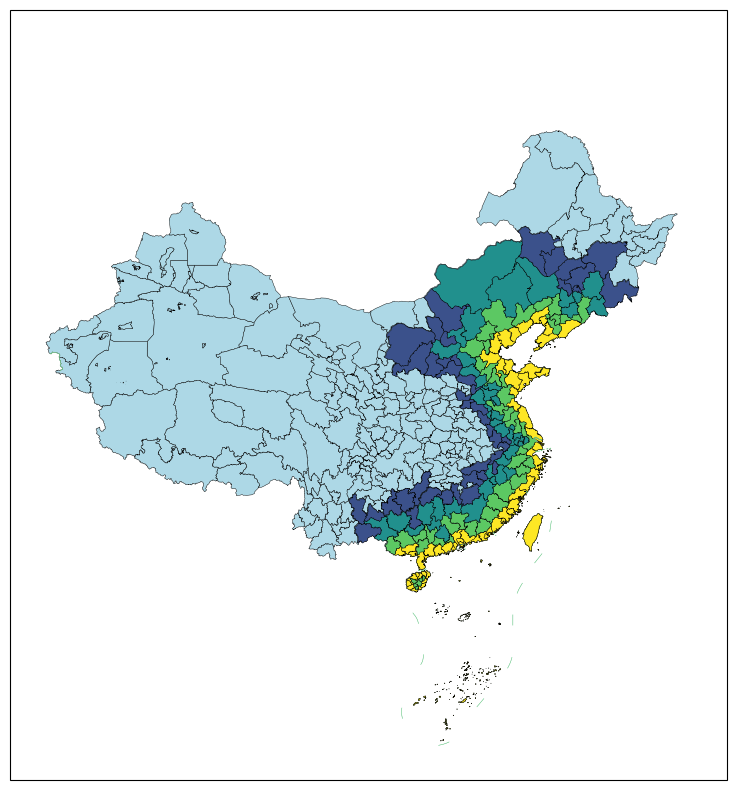

In [ ]:
# 勘误：阳西县-阳江市，海丰县-汕尾市，揭阳县-揭阳市，市辖区(南通市)-
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


# 读取地图数据
# world = gpd.read_file('./chinamap/china_standard_shp/中国地州界.shp')
world = gpd.read_file('./shp2json/chinacity.geojson')
# china = gpd.read_file('./chinamap/geo_china.json')
# world = gpd.read_file('output.geojson')
world = world.to_crs(ccrs.PlateCarree())
# china = china.to_crs(ccrs.PlateCarree())


G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


china_ocean_city = ['丹东市','大连市','营口市','盘锦市','锦州市','葫芦岛市','秦皇岛市','唐山市','天津市','沧州市','滨州市','东营市','潍坊市','烟台市',
                    '威海市','青岛市','日照市','连云港市','盐城市','南通市','上海市','嘉兴市','宁波市','舟山市','台州市','温州市','宁德市','福州市',
                    '莆田市','泉州市','厦门市','漳州市','潮州市','汕头市','揭阳市','汕尾市','惠州市','深圳市','东莞市','广州市','中山市','珠海市',
                    '江门市','阳江市','茂名市','湛江市','北海市','钦州市','防城港市','台湾省','香港特别行政区','澳门特别行政区','海口市','澄迈县',
                    '临高县','儋州市','昌江黎族自治县','东方市','乐东黎族自治县','三亚市','陵水黎族自治县','万宁市','琼海市','文昌市','三沙市']


min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


for city in china_ocean_city:
    city_data = world[world['name'] == city]
    if not city_data.empty:
        city_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=4)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 4):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

# china.plot(ax=ax, color='None', edgecolor='red', linewidth=0.8, transform=ccrs.PlateCarree())



# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=400, bbox_inches='tight')
plt.show()


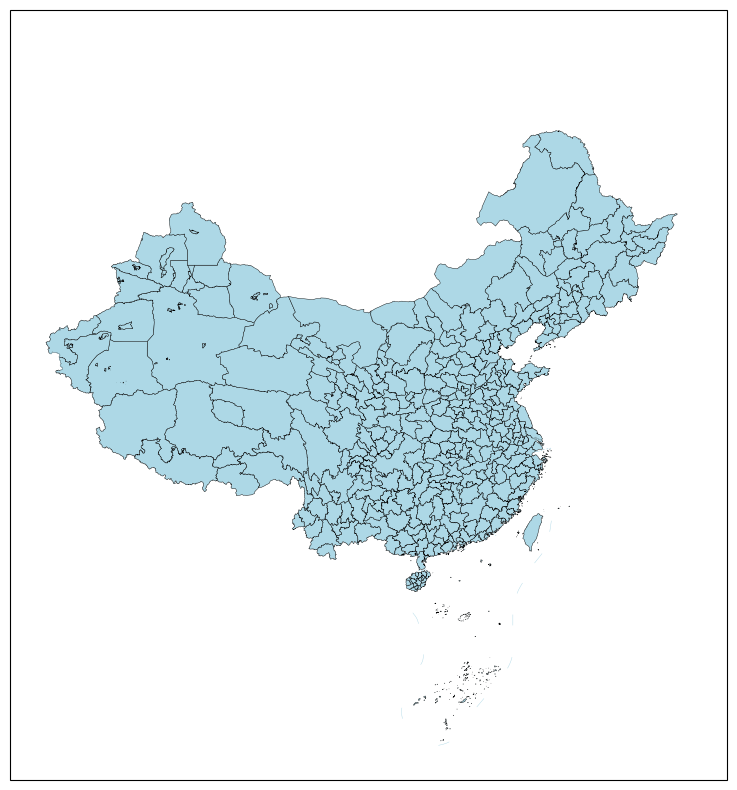

In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

# 读取地图数据
# world = gpd.read_file('./chinamap/province/test.json')
# world = gpd.read_file('output.geojson')
world = gpd.read_file('./shp2json/chinacity.geojson')
world = world.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

plt.show()


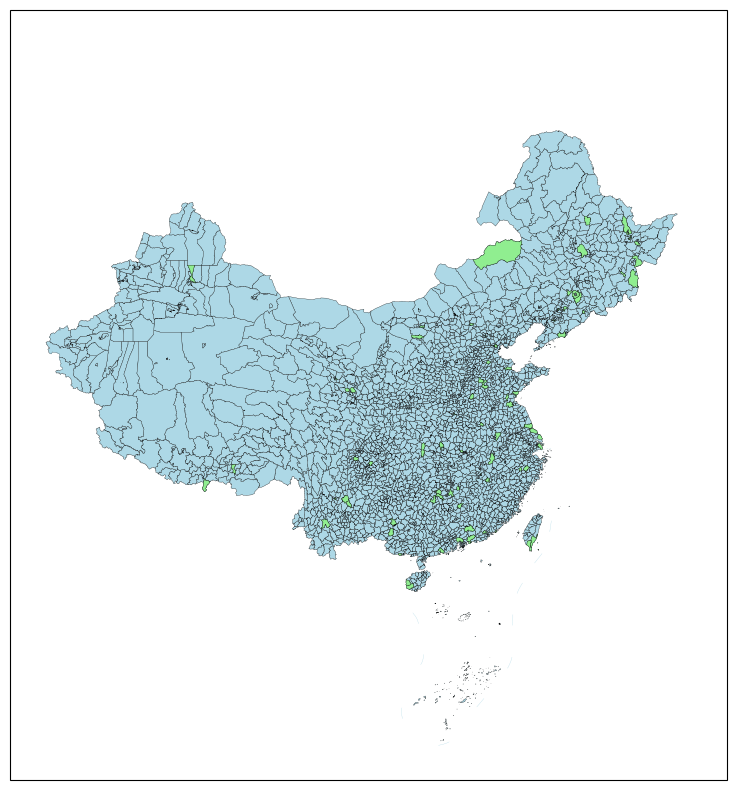

In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

china_ocean_city = ['振兴区','东港市','庄河市','长海县','普兰店区','金州区','中山区','西岗区','沙河口区','甘井子区','旅顺口区','瓦房店市','盖州市','鲅鱼圈区','西市区','大洼区',
                    '兴隆台区','凌海市','太和区','连山区','龙港区','兴城市','绥中县','山海关区','海港区','北戴河区','抚宁区','昌黎县','乐亭县','曹妃甸区',
                    '滦南区','丰南区','滨海新区','黄骅市','无棣县','沾化区','河口区','利津县','垦利区','东营区','广饶县','寿光市','寒亭区','昌邑市','莱州市',
                    '招远市','龙口市','蓬莱区','福山区','芝罘区','莱山区','牟平区','环翠区','荣成市','文登区','乳山市','海阳市','莱阳市','即墨区','崂山区','市北区','市南区',
                    '李沧区','城阳区','胶州市','黄岛区','东港区','岚山区','赣榆区','连云区','灌云县','响水县','滨海县','射阳县','亭湖区','大丰区','东台市',
                    '海安市','如东县','通州区','海门区','启东市','崇明区','太仓市','宝山区','浦东新区','奉贤区','金山区','平湖市','海盐县','余姚市','慈溪市',
                    '镇海区','北仑区','定海区','普陀区','岱山县','嵊泗县','鄞州区','奉化区','宁海县','象山县','三门县','临海市','椒江区','路桥区','温岭市','玉环市',
                    '乐清市','洞头区','龙湾区','瑞安市','平阳县','龙港市','苍南县','福鼎市','霞浦县','福安市','蕉城区','罗源县','连江县','马尾区','长乐区','福清市',
                    '平潭县','涵江区','荔城区','秀屿区','城厢区','仙游县','泉港区','惠安县','洛江区','丰泽区','晋江市','石狮市','南安市','翔安区','同安区','集美区',
                    '海沧区','龙海区','思明区','湖里区','金门县','漳浦县','云霄县','东山县','诏安县','饶平县','澄海区','南澳县','龙湖区','濠江区','金平区','榕城区',
                    '潮阳区','潮南区','惠来县','陆丰市','城区','海丰县','惠东县','惠阳区','龙岗区','盐田区','福田区','南山区','宝安区','东莞市','南沙区','中山市','香洲区',
                    '金湾区','斗门区','新会区','台山市','阳东区','江城区','阳西县','电白区','吴川市','坡头区','霞山区','麻章区','赤坎区','遂溪县','雷州市','徐闻县',
                    '廉江市','合浦县','铁山港区','银海区','海城区','钦南区','防城区','港口区','东兴市','文昌市','美兰区','龙华区','秀英区','澄迈县','临高县','儋州市',
                    '昌江黎族自治县','东方市','乐东黎族自治县','崖州区','天涯区','吉阳区','海棠区','陵水黎族自治县','万宁市','琼海市','西沙区','南沙区','基隆市','新北市',
                    '桃园市','新竹市','新竹县','苗栗县','台中市','彰化县','云林县','嘉义县','台南市','高雄市','屏东县','台东县','花莲县','宜兰县']

china = gpd.read_file('./shp2json/chinacounty.geojson')
china = china.to_crs(ccrs.PlateCarree())

# listCounty = china[(china['name'].isin(china_ocean_city))]
listCounty = china[(china['name'].str.contains('东'))]
listCounty = listCounty.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
china.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
listCounty.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())

legend_elements = [
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightgreen', markersize=10, label='距离上海浦东机场场更近', linestyle='None'),
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightgreen', markersize=10, label='距离上海虹桥机场更近', linestyle='None'),
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightcoral', markersize=10, label='距离杭州萧山机场更近', linestyle='None'),
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightyellow', markersize=10, label='距离南京禄口机场更近', linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize='large')
legend.get_frame().set_facecolor('lightgray')


# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())
# plt.savefig('chinacounty.png', dpi=800, bbox_inches='tight')
plt.show()


In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

china = gpd.read_file('./shp2json/countybyprovince/河北省_县.geojson')
china = china.to_crs(ccrs.PlateCarree())
list_county = china[china['name'].str.contains('[东南西北]', regex=True)]
print(len(list_county))




15


In [28]:
import geopandas as gpd
import cartopy.crs as ccrs
import os

# 目标目录路径
directory_path = './shp2json/countybyprovince'

# 存储每个文件的统计结果
file_counts = []

# 遍历目录中的所有 GeoJSON 文件
for filename in os.listdir(directory_path):
    if filename.endswith('.geojson'):
        file_path = os.path.join(directory_path, filename)
        
        # 读取 GeoJSON 文件
        china = gpd.read_file(file_path)
        china = china.to_crs(ccrs.PlateCarree())
        
        # 统计当前文件中东南西北的总出现次数
        list_county = china[china['name'].str.contains('[东南西北]', regex=True)]
        
        # 记录结果
        file_counts.append((filename, len(list_county)))

# 按照统计数字降序排列
file_counts.sort(key=lambda x: x[1], reverse=True)

# 格式化输出结果
file_counts_str = [f"{filename}: {count}" for filename, count in file_counts]
print("统计结果：")
print(", ".join(file_counts_str))


统计结果：
黑龙江省_县.geojson: 19, 广西壮族自治区_县.geojson: 18, 广东省_县.geojson: 16, 河北省_县.geojson: 15, 辽宁省_县.geojson: 15, 四川省_县.geojson: 13, 云南省_县.geojson: 12, 山东省_县.geojson: 12, 江西省_县.geojson: 11, 吉林省_县.geojson: 10, 河南省_县.geojson: 10, 湖南省_县.geojson: 10, 湖北省_县.geojson: 9, 天津市_县.geojson: 8, 安徽省_县.geojson: 8, 浙江省_县.geojson: 8, 甘肃省_县.geojson: 8, 重庆市_县.geojson: 7, 内蒙古自治区_县.geojson: 6, 江苏省_县.geojson: 6, 青海省_县.geojson: 5, 海南省_县.geojson: 4, 福建省_县.geojson: 4, 贵州省_县.geojson: 4, 陕西省_县.geojson: 4, 西藏自治区_县.geojson: 3, 北京市_县.geojson: 2, 宁夏回族自治区_县.geojson: 2, 新疆维吾尔自治区_县.geojson: 2, 上海市_县.geojson: 1, 山西省_县.geojson: 1, 台湾省_市.geojson: 0, 澳门特别行政区_省.geojson: 0, 香港特别行政区_市.geojson: 0


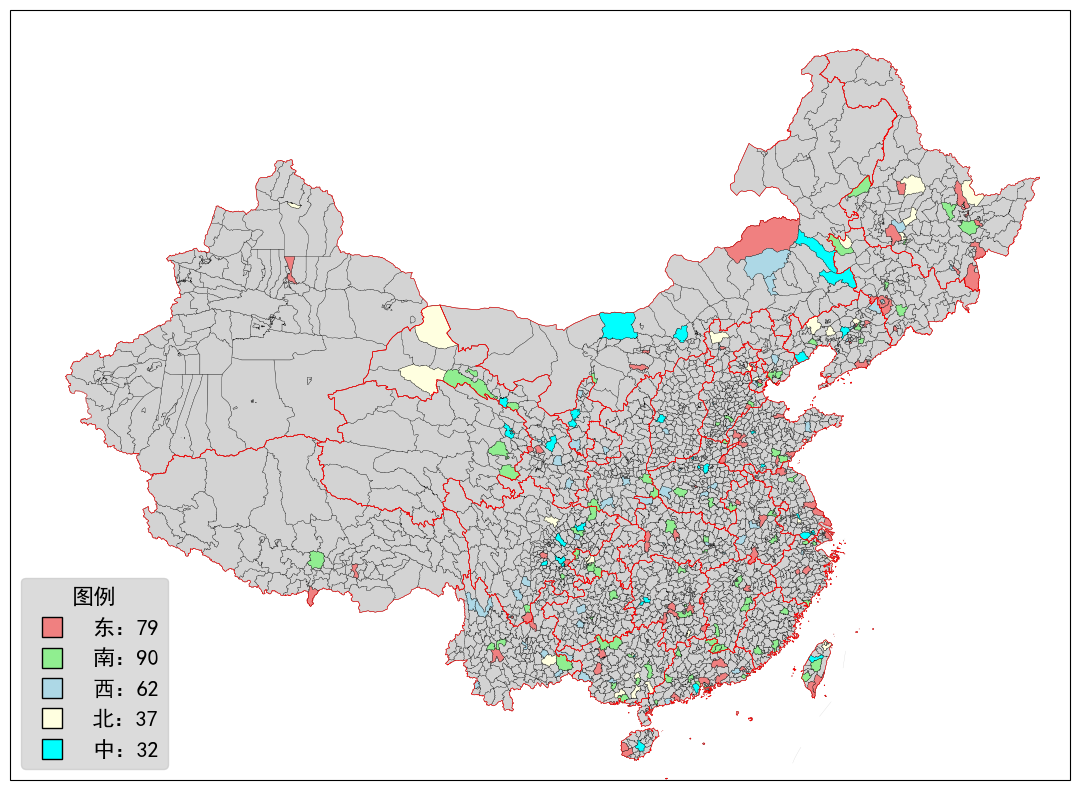

In [30]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def countUnit(china, key):
    listCounty = china[(china['name'].str.contains(key))]
    return listCounty, len(listCounty)

china = gpd.read_file('./shp2json/chinacounty.geojson')
china = china.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

list1, num1 = countUnit(china, '东')
list2, num2 = countUnit(china, '南')
list3, num3 = countUnit(china, '西')
list4, num4 = countUnit(china, '北')
list5, num5 = countUnit(china, '中')
list1 = list1.to_crs(ccrs.PlateCarree())
list2 = list2.to_crs(ccrs.PlateCarree())
list3 = list3.to_crs(ccrs.PlateCarree())
list4 = list4.to_crs(ccrs.PlateCarree())
list5 = list5.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
china.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list1.plot(ax=ax, color='lightcoral', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list2.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list3.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list4.plot(ax=ax, color='lightyellow', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list5.plot(ax=ax, color='cyan', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='red', linewidth=0.4, transform=ccrs.PlateCarree())

legend_elements = [
    Line2D([0], [0], marker='s', color='k', markerfacecolor='lightcoral', markersize=14, label='东：' + str(num1), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='lightgreen', markersize=14, label='南：' + str(num2), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='lightblue', markersize=14, label='西：' + str(num3), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='lightyellow', markersize=14, label='北：' + str(num4), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='cyan', markersize=14, label='中：' + str(num5), linestyle='None')
]

legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize=16,prop={'size': 16})
legend.get_frame().set_facecolor('lightgray')




# 设置地图显示范围
ax.set_extent([70, 137, 17, 55], crs=ccrs.PlateCarree())
plt.savefig('chinacounty3.png', dpi=800, bbox_inches='tight')
plt.show()


(0.993248, 0.906157, 0.143936, 1.0)
['龙华区', '宝安区', '东莞市', '盐田区', '龙岗区', '惠阳区', '台山市', '阳东区', '新会区', '南山区', '福田区', '北区', '元朗区', '滦南县', '乐亭县', '曹妃甸区', '丰南区', '昌黎县', '惠东县', '滨海新区', '大丰区', '亭湖区', '东台市', '射阳县', '仙游县', '城厢区', '涵江区', '洛江区', '泉港区', '南安市', '连山区', '凌海市', '滨海县', '响水县', '灌云县', '荔城区', '秀屿区', '福清市', '南沙区', '西沙区', '合浦县', '银海区', '海城区', '铁山港区', '钦南区', '廉江市', '沾化区', '利津县', '无棣县', '河口区', '寿光市', '盖州市', '大洼区', '鲅鱼圈区', '西市区', '普兰店区', '庄河市', '瓦房店市', '防城区', '广饶县', '寒亭区', '昌邑市', '胶州市', '莱州市', '黄岛区', '黄骅市', '东营区', '龙港市', '平阳县', '苍南县', '太仓市', '海门区', '宝山区', '通州区', '瑞安市', '龙湾区', '乐清市', '洞头区', '温岭市', '澳门特别行政区', '香洲区', '中山市', '斗门区', '海安市', '饶平县', '诏安县', '澄海区', '福安市', '福鼎市', '金平区', '龙湖区', '榕城区', '海丰县', '陆丰市', '城区', '云霄县', '漳浦县', '龙海区', '绥中县', '山海关区', '海港区', '兴城市', '平湖市', '龙港区', '太和区', '东山县', '即墨区', '崂山区', '城阳区', '莱阳市', '抚宁区', '东港区', '李沧区', '市南区', '市北区', '招远市', '思明区', '湖里区', '海沧区', '集美区', '北戴河区', '岚山区', '宜兰县', '新竹县', '新北市', '桃园市', '台中市', '花莲县', '新竹市', '苗栗县', '彰化县', '云林县', '嘉义县', '余姚市', '海盐县', '澎湖县', '

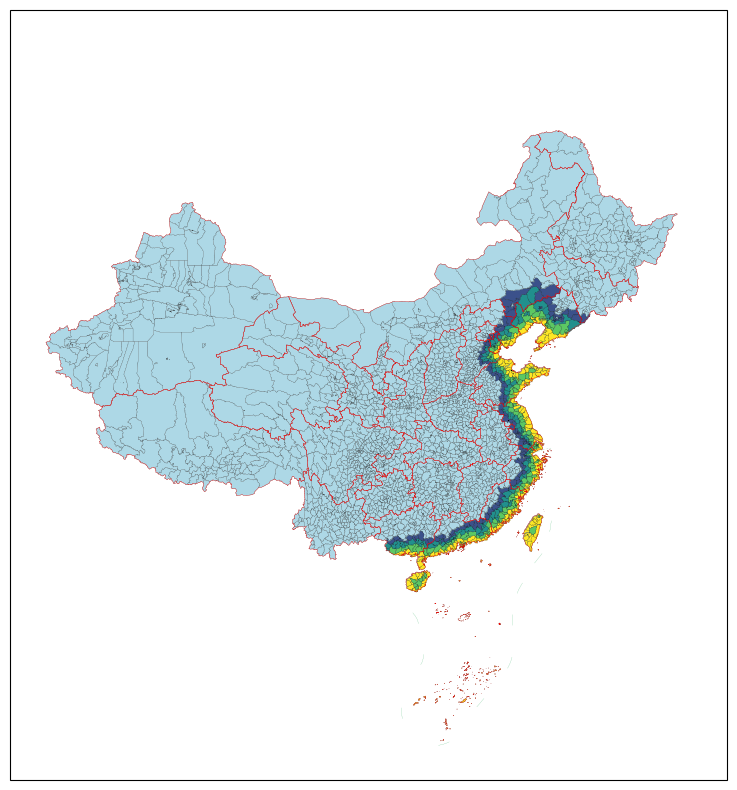

In [1]:
# 按县
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax

# 读取地图数据
world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


china_ocean_city = ['振兴区','东港市','庄河市','长海县','普兰店区','金州区','中山区','西岗区','沙河口区','甘井子区','旅顺口区','瓦房店市','盖州市','鲅鱼圈区','西市区',
                    '大洼区','兴隆台区','凌海市','太和区','连山区','龙港区','兴城市','绥中县','山海关区','海港区','北戴河区','抚宁区','昌黎县','乐亭县','曹妃甸区',
                    '滦南县','丰南区','滨海新区','黄骅市','无棣县','沾化区','河口区','利津县','垦利区','东营区','广饶县','寿光市','寒亭区','昌邑市','莱州市',
                    '招远市','龙口市','蓬莱区','福山区','芝罘区','莱山区','牟平区','环翠区','荣成市','文登区','乳山市','海阳市','莱阳市','即墨区','崂山区','市北区',
                    '市南区','李沧区','城阳区','胶州市','黄岛区','东港区','岚山区','赣榆区','连云区','灌云县','响水县','滨海县','射阳县','亭湖区','大丰区','东台市',
                    '海安市','如东县','通州区','海门区','启东市','崇明区','太仓市','宝山区','浦东新区','奉贤区','金山区','平湖市','海盐县','余姚市','慈溪市',
                    '镇海区','北仑区','定海区','普陀区','岱山县','嵊泗县','鄞州区','奉化区','宁海县','象山县','三门县','临海市','椒江区','路桥区','温岭市','玉环市',
                    '乐清市','洞头区','龙湾区','瑞安市','平阳县','龙港市','苍南县','福鼎市','霞浦县','福安市','蕉城区','罗源县','连江县','马尾区','长乐区','福清市',
                    '平潭县','涵江区','荔城区','秀屿区','城厢区','仙游县','泉港区','惠安县','洛江区','丰泽区','晋江市','石狮市','南安市','翔安区','同安区','集美区',
                    '海沧区','龙海区','思明区','湖里区','金门县','漳浦县','云霄县','东山县','诏安县','饶平县','澄海区','南澳县','龙湖区','濠江区','金平区','榕城区',
                    '潮阳区','潮南区','惠来县','陆丰市','城区','海丰县','惠东县','惠阳区','龙岗区','盐田区','福田区','南山区','宝安区','东莞市','南沙区','中山市','香洲区',
                    '金湾区','斗门区','新会区','台山市','阳东区','江城区','阳西县','电白区','吴川市','坡头区','霞山区','麻章区','赤坎区','遂溪县','雷州市','徐闻县',
                    '廉江市','合浦县','铁山港区','银海区','海城区','钦南区','防城区','港口区','东兴市','文昌市','美兰区','龙华区','秀英区','澄迈县','临高县','儋州市',
                    '昌江黎族自治县','东方市','乐东黎族自治县','崖州区','天涯区','吉阳区','海棠区','陵水黎族自治县','万宁市','琼海市','西沙区','南沙区','基隆市','新北市',
                    '桃园市','新竹市','新竹县','苗栗县','台中市','彰化县','云林县','嘉义县','台南市','高雄市','屏东县','台东县','花莲县','宜兰县','澎湖县','北区','元朗区',
                    '屯门区','大埔区','西贡区','沙田区','荃湾区','葵青区','深水埗区','油尖旺区','九龙城区','观塘区','黄大仙区','中西区','湾仔区','东区','南区','离岛区','澳门特别行政区']


min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())


# for city in china_ocean_city:
#     city_data = world[world['name'] == city]
#     if not city_data.empty:
#         city_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())


stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=4)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 4):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())

province.plot(ax=ax, color='none', edgecolor='red', linewidth=0.2, transform=ccrs.PlateCarree())

# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=800, bbox_inches='tight')
plt.show()


In [39]:
import json
from collections import Counter
with open("./shp2json/countybyprovince/河北省_县.geojson", "r", encoding="utf-8") as f:
    data = json.load(f)

names = "".join([feature["properties"]["name"] for feature in data["features"]])
count = Counter(names)
sorted_result = dict(sorted(count.items(), key=lambda x: x[1], reverse=True))
print(sorted_result)




{'县': 97, '区': 49, '市': 21, '城': 11, '安': 11, '平': 9, '河': 8, '族': 7, '州': 7, '自': 6, '治': 6, '南': 6, '阳': 5, '满': 5, '新': 5, '桥': 5, '西': 4, '滦': 4, '兴': 4, '宁': 4, '山': 4, '清': 3, '大': 3, '鹿': 3, '华': 3, '都': 3, '定': 3, '泽': 3, '矿': 3, '化': 3, '丰': 3, '广': 3, '武': 3, '北': 3, '高': 3, '临': 3, '乡': 3, '海': 3, '隆': 3, '水': 2, '怀': 2, '回': 2, '涿': 2, '永': 2, '涞': 2, '迁': 2, '乐': 2, '任': 2, '唐': 2, '阜': 2, '井': 2, '陉': 2, '晋': 2, '丘': 2, '古': 2, '曲': 2, '强': 2, '邑': 2, '路': 2, '龙': 2, '源': 2, '青': 2, '深': 2, '东': 2, '泉': 2, '峰': 2, '双': 2, '苑': 1, '徐': 1, '莲': 1, '池': 1, '原': 1, '赤': 1, '来': 1, '厂': 1, '固': 1, '文': 1, '香': 1, '辛': 1, '集': 1, '襄': 1, '黄': 1, '骅': 1, '间': 1, '亭': 1, '藁': 1, '和': 1, '信': 1, '玉': 1, '田': 1, '裕': 1, '宫': 1, '沙': 1, '泊': 1, '头': 1, '长': 1, '三': 1, '霸': 1, '围': 1, '场': 1, '蒙': 1, '万': 1, '全': 1, '宣': 1, '下': 1, '花': 1, '园': 1, '宽': 1, '崇': 1, '礼': 1, '周': 1, '馆': 1, '陶': 1, '景': 1, '魏': 1, '故': 1, '枣': 1, '鸡': 1, '饶': 1, '次': 1, '邱': 1, '遵': 1, '冶': 1, '张': 1, '开

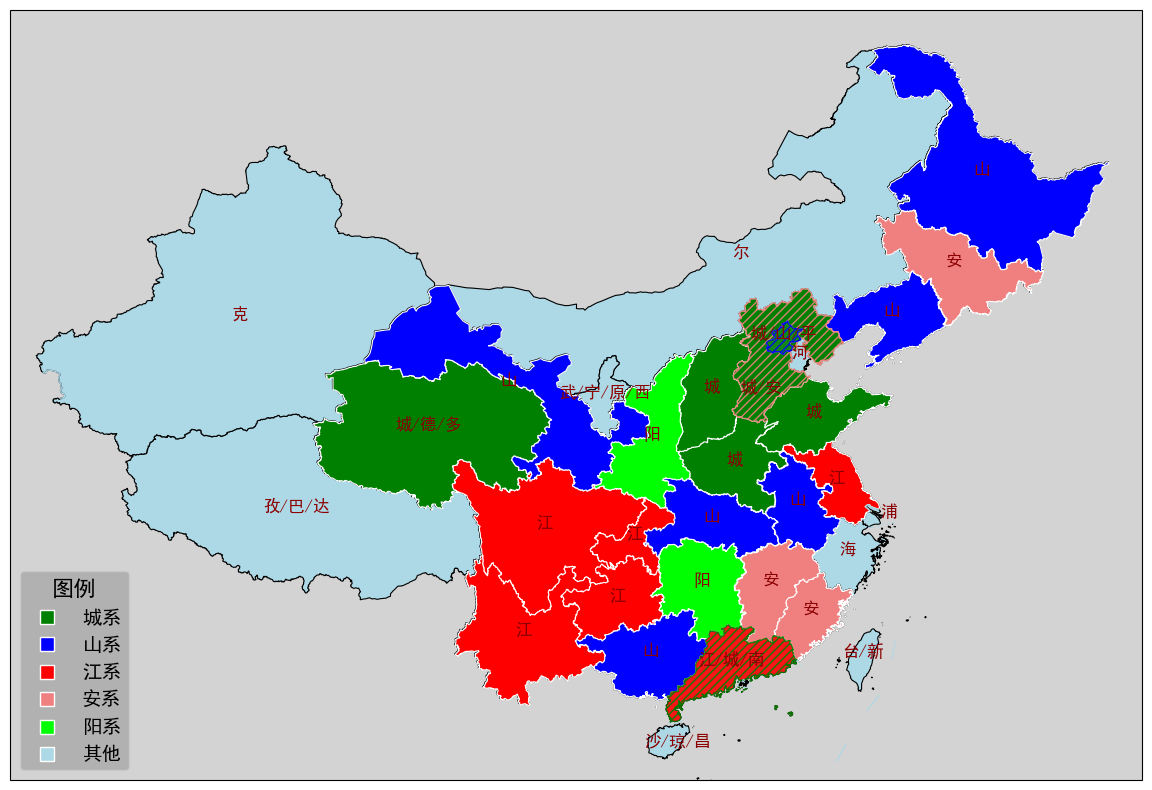

In [59]:
# 中国地名常见字
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects

from shapely.geometry import Polygon
from matplotlib.patches import PathPatch

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def loopFillColor(china, countryList, color):
    for country in countryList:
        country_data = china[china['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='white', linewidth=0.8, transform=ccrs.PlateCarree())


province_to_fill1 = ['上海市', '云南省', '内蒙古自治区', '北京市', '吉林省', '四川省', '天津市','宁夏回族自治区', '安徽省', '山东省', '山西省', 
                     '广东省','广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', 
                     '甘肃省', '福建省', '西藏自治区', '贵州省', '辽宁省', '重庆市', '陕西省', '青海省', '黑龙江省', '台湾省']

count_data = {'上海市': "浦", '云南省': '江', '内蒙古自治区': '尔','北京市': '城/山/平', '吉林省': '安', '四川省': '江', 
              '天津市': '河','宁夏回族自治区': '武/宁/原/西', '安徽省': '山', '山东省': '城', '山西省': '城', 
              '广东省': '江/城/南','广西壮族自治区': '山', '新疆维吾尔自治区': '克', '江苏省': '江', '江西省': '安', 
              '河北省': '城/安', '河南省': '城', '浙江省': '海', '海南省': '沙/琼/昌', '湖北省': '山', '湖南省': '阳', 
              '甘肃省': '山', '福建省': '安', '西藏自治区': '孜/巴/达', '贵州省': '江', '辽宁省': '山', '重庆市': '江', 
              '陕西省': '阳', '青海省': '城/德/多', '黑龙江省': '山', '台湾省': '台/新'}

china = gpd.read_file('./shp2json/chinaprovince.geojson')
china = china.to_crs(ccrs.PlateCarree())
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=0)})
ax.set_facecolor('lightgrey')
china.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.8, transform=ccrs.PlateCarree())
jiang_group = ['四川省', '重庆市', '贵州省', '云南省', '江苏省']
loopFillColor(china, jiang_group, 'red')
cheng_group = ['山西省', '山东省', '河北省', '河南省', '青海省']
loopFillColor(china, cheng_group, 'green')
shan_group = ['甘肃省', '黑龙江省', '辽宁省', '安徽省', '湖北省', '广西壮族自治区']
loopFillColor(china, shan_group, 'blue')
an_group = ['福建省', '江西省', '吉林省']
loopFillColor(china, an_group, 'lightcoral')
yang_group = ['湖南省', '陕西省']
loopFillColor(china, yang_group, 'lime')

guangdong_data = china[china['name'] == '广东省']
if not guangdong_data.empty:
    guangdong_data.plot(
        ax=ax,
        facecolor='red',
        edgecolor='green',
        linewidth=0.8,
        hatch='////',
        alpha=0.9,
        transform=ccrs.PlateCarree()
    )

hebeidata = china[china['name'] == '河北省']
if not hebeidata.empty:
    hebeidata.plot(
        ax=ax,
        facecolor='green',
        edgecolor='lightcoral',
        linewidth=0.8,
        hatch='////',
        alpha=0.9,
        transform=ccrs.PlateCarree()
    )

beijingdata = china[china['name'] == '北京市']
if not beijingdata.empty:
    beijingdata.plot(
        ax=ax,
        facecolor='green',
        edgecolor='blue',
        linewidth=0.8,
        hatch='////',
        alpha=0.9,
        transform=ccrs.PlateCarree()
    )


for province in province_to_fill1:
    province_data = china[china['name'] == province]
    province_geom = province_data.geometry.centroid
    for x, y in zip(province_geom.x, province_geom.y):
        words = count_data.get(province, "")
        words_multiline = '/'.join(words.split('/'))
        if words_multiline:
            if province == '河北省':
                ax.text(x-1, y-2, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')
            elif province == '海南省':
                ax.text(x, y+1, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')
            elif province == '上海市':
                ax.text(x+1, y, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')
            else:
                ax.text(x, y, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='城系', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='山系', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='江系', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='安系', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lime', markersize=10, label='阳系', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightblue', markersize=10, label='其他', linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize=16,prop={'size': 14})
legend.get_frame().set_facecolor('darkgray')
ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_extent([72, 137, 17, 55], crs=ccrs.PlateCarree())

plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# 欧洲各国语言中的茶
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# plt.rcParams['font.sans-serif'] = ['SimHei','Times New Roman']
# plt.rcParams['axes.unicode_minus'] = False 

world = gpd.read_file('./worldmap1/World_countries.shp')

world = world.to_crs(ccrs.PlateCarree())

countries_to_fill1 = ['英国', '法国', '西班牙', '德国', '瑞士', '意大利', '荷兰', '比利时', '丹麦', '冰岛', '瑞典', '挪威', '芬兰', '爱沙尼亚', '拉脱维亚',
                      '立陶宛', '波兰', '爱尔兰', '奥地利', '匈牙利', '卢森堡', '安道尔', '圣马力诺', '列支敦士登']
countries_to_fill2 = ['葡萄牙', '俄罗斯联邦', '白俄罗斯', '乌克兰', '土耳其', '摩尔多瓦', '捷克', '斯洛伐克', '罗马尼亚', '保加利亚', '希腊', '阿尔巴尼亚', '塞尔维亚', '斯洛文尼亚', '克罗地亚', '黑山共和国',
                      '波黑', '塞浦路斯', '前南马其顿', '格鲁吉亚']

country_word = {
    "英国": "tea/ti/te",
    "爱尔兰": "tae",
    "西班牙": "te",
    "法国": "thé",
    "荷兰": "thee",
    "德国": "Tee",
    "意大利": "tè",
    "葡萄牙": "chá",
    "罗马尼亚": "ceai",
    "捷克": "čaj",
    "波兰": "herbata",
    "挪威": "te",
    "瑞典": "te",
    "芬兰": "tee",
    "冰岛": "te",
    "希腊": "τσάι",
    "土耳其": "çay",
    "白俄罗斯": "чай",
    "立陶宛": "arbata",
    "塞尔维亚": "чај",
    "保加利亚": "чай",
    "格鲁吉亚": "ჩაი",
    "拉脱维亚": "tēja",
    "卢森堡": "Téi",
    "匈牙利": "tea"
}

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller()})


world.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

for country in countries_to_fill1:
    country_data = world[world['FCNAME'] == country]
    if not country_data.empty:
        country_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
    country_geom = country_data.geometry.centroid
    for x, y in zip(country_geom.x, country_geom.y):
        words = country_word.get(country, "")
        words_multiline = '\n'.join(words.split('/'))
        if words_multiline:
            ax.text(x, y, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')

for country in countries_to_fill2:
    country_data = world[world['FCNAME'] == country]
    if not country_data.empty:
        country_data.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
    country_geom = country_data.geometry.centroid
    for x, y in zip(country_geom.x, country_geom.y):
        words = country_word.get(country, "")
        words_multiline = '\n'.join(words.split('/'))
        if words_multiline:
            ax.text(x, y, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen', markersize=10, label='tea', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightblue', markersize=10, label='chai', linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='lower left', title='LEGEND', title_fontsize='large')
legend.get_frame().set_facecolor('lightgray')


ax.tick_params(axis='both', which='both', length=0, labelsize=0)

ax.set_extent([45, -25, 30, 68], crs=ccrs.PlateCarree())


plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()
